# EMBEDDINGS

The current state-of-the-art approach to natural language understanding is using pre-trained language models by fine-tuning them for specific (downstream) tasks such as question answering or sentiment analysis.We followed that recipe and developed FinBERT as a BERT-based language model with a deeper understanding of financial language and fine-tuned it for sentiment classification

[Medium Blog of FinBERT](https://medium.com/prosus-ai-tech-blog/finbert-financial-sentiment-analysis-with-bert-b277a3607101)

Praticamente è BERT, pre-trainato ancora però su un dataset finanziario e poi finetunato su un task specifico finanziario con le label per sentiment analysis.
"Bert sa parlare, FinBert sa parlare come un trader"

**Vocabolario**
Vocabolario: insieme di tutte le parole o sub-token che il modello riconosce. Ogni parola o sub-token è associato a un ID numerico che il modello utilizza per riferirsi a quella parola.
Bert si basa su WordPiece, se una parola non è nel vocabolario, viene suddivisa in sub-token che sono nel vocabolario.

Il vocabolario di FinBERT è costruito sulla base del vocabolario di BERT base (con circa 30,000 parole e sub-token), ma con un'aggiunta di termini specifici del dominio finanziario. Che si sono aggiunti con il training sul dataset finanziario.

In [25]:
from transformers import AutoTokenizer, AutoModel
import torch
%load_ext autoreload
%autoreload 2

# Carica il modello FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-pretrain")
model = AutoModel.from_pretrained("yiyanghkust/finbert-pretrain")

Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Il token [CLS] è comunemente usato come rappresentazione aggregata dell'intera sequenza di testo, poiché è stato progettato per "riassumere" il significato complessivo della frase/testo.

Estrarre il token [CLS] è una pratica standard per ottenere embedding a livello di frase o documento.

In [24]:
def get_finbert_embedding(model, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # prende il CLS dell'ultimo layer
    # embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()    # (batch_size, seq_length, hidden_size)

    # Ottieni gli ultimi 4 hidden states
    hidden_states = outputs.hidden_states  # Lista di tensori (1 per ogni layer)
    last_4_layers = hidden_states[-4:]     # Ultimi 4 layer
    # Calcola la media dei 4 layer
    stacked_layers = torch.stack(last_4_layers, dim=0)  # Forma: (4, batch_size, seq_length, hidden_size)
    avg_last_4 = torch.mean(stacked_layers, dim=0)      # Forma: (batch_size, seq_length, hidden_size)
    # Usa il token [CLS] (primo token) come rappresentazione del testo
    embedding = avg_last_4[:, 0, :].squeeze().numpy()   # Forma: (hidden_size,)

    return embedding

Da quale layer prendere CLS? 

L'ultimo layer è quello che contiene la rappresentazione più contestualizzata del testo, in quanto incorpora informazioni di alto livello che derivano dai livelli precedenti. Pensando all'architettura dei transformer, ultimo livello vedere con self attention tutti gli altri prima. 
--> In BERT il vettore [CLS] nel layer finale è stato ottimizzato per compiti come la classificazione del sentiment, l'analisi di relazioni tra frasi, ecc.

i layer intermedi possono fornire rappresentazioni migliori, poiché l'ultimo layer potrebbe essere troppo ottimizzato per compiti specifici (ad esempio, classificazione) e meno utile per compiti più generali.
In BERT base, i layer 10, 11, 12 (su 12 totali) sono spesso usati per compiti generali.

Dimensione degli embeddings?

hidden_size = 768 (BERT-base architecture).

In [28]:
# Testa con una query
query = "I tassi di interesse influenzeranno il mercato azionario."
embedding = get_finbert_embedding(model, query)
embedding

array([-8.95898581e-01, -4.08190012e-01, -8.80250216e-01,  1.09812580e-01,
        1.86102819e+00, -7.89009571e-01, -4.30659056e-02,  6.72866479e-02,
       -1.20873183e-01,  2.02040672e-01,  8.44451070e-01, -1.98883131e-01,
        1.08144486e+00,  6.01399004e-01,  5.93838811e-01,  4.51535322e-02,
        9.57134843e-01, -3.71081293e-01,  5.04959345e-01, -4.63009059e-01,
       -6.47842824e-01,  4.30272043e-01, -2.42120981e-01,  1.98430810e-02,
        4.51584458e-01, -3.07340354e-01,  5.65959990e-01,  1.69821024e-01,
        1.06975026e-02, -1.59236944e+00, -8.77703503e-02, -1.11272447e-01,
        5.85861504e-04,  1.52525938e+00, -2.10227221e-01,  5.04345417e-01,
        1.23004764e-01, -4.88566995e-01, -8.44560027e-01, -4.64759648e-01,
       -1.32661968e-01,  4.15720940e-01, -8.16631690e-03, -4.54280287e-01,
       -3.50854546e-01,  1.58479139e-01, -4.68695641e-01, -8.58201802e-01,
        1.47375315e-01, -3.05427492e-01,  2.00828254e-01, -4.70515013e-01,
        4.03940260e-01, -

Utilizzo pratico per il nostro dataset

In [1]:
import os
os.chdir("..")  # Torna alla directory principale del progetto
current_directory = os.getcwd()
print(current_directory)

from src.dataset import FinanceRAGDataset

c:\Users\alice\Desktop\UNIBO\2_Anno\2_semestre\NLP-torroni\PW\FinanceRag


In [3]:
dataset_manager = FinanceRAGDataset("data")
print("Available datasets:", dataset_manager.list_datasets())

Available datasets: ['ConvFinQA', 'FinQA', 'MultiHeritt', 'TATQA']


# ConvFinQA

No missing values

corpus: 2066 
queries: 421 

column title is always blank ""

In [23]:
import pandas as pd
# Load corpus and queries from a specific dataset
convfinqa_corpus, convfinqa_queries, convfinqa_qrels = dataset_manager.load_dataset("ConvFinQA")

# Print sample entries
print("Sample corpus entry:", convfinqa_corpus[0])
print("Sample query entry:", convfinqa_queries[0])

corpus_df = pd.DataFrame(convfinqa_corpus)
queries_df = pd.DataFrame(convfinqa_queries)

corpus_df.drop(columns=["title"], inplace=True)
queries_df.drop(columns=["title"], inplace=True)

print("\nCorpus DataFrame Info:")
print(corpus_df.shape)
print("\nQueries DataFrame Info:")
print(queries_df.shape)

Sample corpus entry: {'_id': 'dd4bff516', 'title': '', 'text': 'containerboard , kraft papers and saturating kraft .\nkapstone also owns victory packaging , a packaging solutions distribution company with facilities in the u.s. , canada and mexico .\nwe have included the financial results of kapstone in our corrugated packaging segment since the date of the acquisition .\non september 4 , 2018 , we completed the acquisition ( the 201cschl fcter acquisition 201d ) of schl fcter print pharma packaging ( 201cschl fcter 201d ) .\nschl fcter is a leading provider of differentiated paper and packaging solutions and a german-based supplier of a full range of leaflets and booklets .\nthe schl fcter acquisition allowed us to further enhance our pharmaceutical and automotive platform and expand our geographical footprint in europe to better serve our customers .\nwe have included the financial results of the acquired operations in our consumer packaging segment since the date of the acquisition 

,_id,text
0,dd4bff516,"containerboard , kraft papers and saturating k..."
1,dd4c55cc2,"entergy mississippi , inc .\nmanagement's fina..."
2,dd4c5a718,"we have a five year $ 1350 million revolving ,..."
3,dd4be0184,the agreements that govern the indebtedness in...
4,dd4b93b5e,"during 2005 , we amended our $ 1.0 billion uns..."


### Analyze Text Lengths in Corpus

Max text length: 15092
Average text length: 4409.56485963214


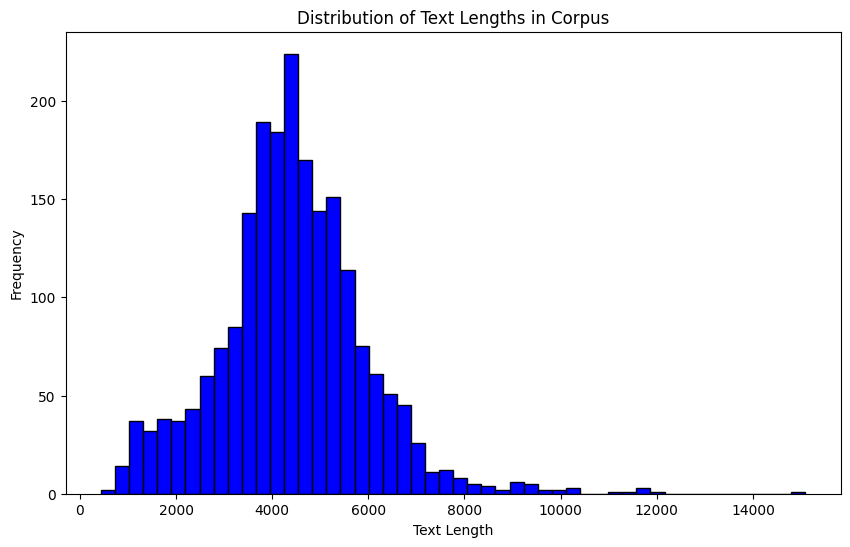

In [32]:
import matplotlib.pyplot as plt

# Calculate text lengths
corpus_df['text_length'] = corpus_df['text'].apply(len)

# Calculate max and average lengths
max_length = corpus_df['text_length'].max()
average_length = corpus_df['text_length'].mean()

print(f"Max text length: {max_length}")
print(f"Average text length: {average_length}")

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(corpus_df['text_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths in Corpus')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Max tokenized text length: 512
Average tokenized text length: 501.10164569215874


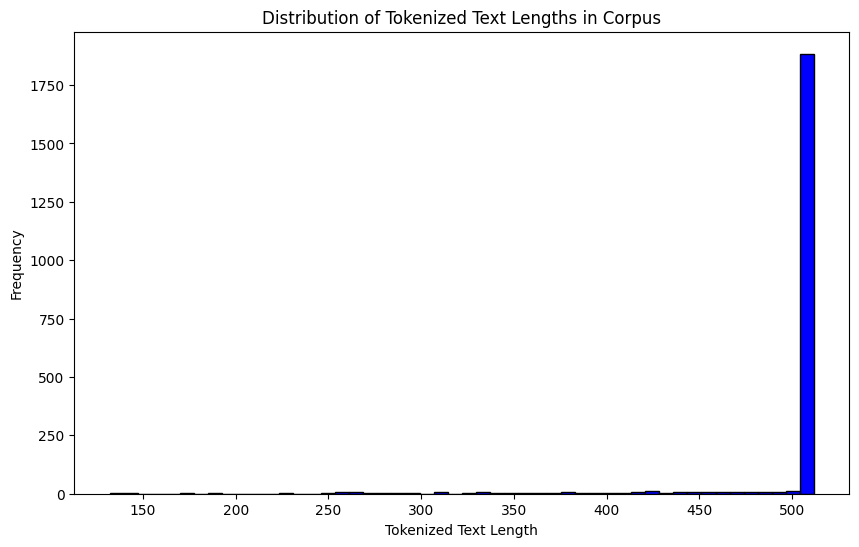

In [31]:
# Tokenizza i testi nel corpus
corpus_df['tokenized_text'] = corpus_df['text'].apply(lambda x: tokenizer(x, truncation=True, max_length=512)['input_ids'])

# Calcola la lunghezza dei testi tokenizzati
corpus_df['tokenized_length'] = corpus_df['tokenized_text'].apply(len)

# Calcola la lunghezza massima e media dei testi tokenizzati
max_tokenized_length = corpus_df['tokenized_length'].max()
average_tokenized_length = corpus_df['tokenized_length'].mean()

print(f"Max tokenized text length: {max_tokenized_length}")
print(f"Average tokenized text length: {average_tokenized_length}")

# Plot della distribuzione delle lunghezze dei testi tokenizzati
plt.figure(figsize=(10, 6))
plt.hist(corpus_df['tokenized_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Tokenized Text Lengths in Corpus')
plt.xlabel('Tokenized Text Length')
plt.ylabel('Frequency')
plt.show()